## stacking 集成算法：深度神经网络
基础学习器抽取特征，次级学习器融合。5折。
- 8 神经网络回归

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

import time
from sklearn.model_selection import cross_val_score, train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
Y_Standard = True
path_train = '../data/new/train=all/'
path_test = '../data/new/test/'

val_path = '../data/val/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s.csv'
summit_path = '../data/summit/' #保存提交文件，测试集测试结果 
out_name = '%ssummit=stacking-%s-%s.csv' # 生成的结果文件名称

train_part_num = 5 #训练集拆分个数
target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id', 'register_time', 'wood_add_value', 'wood_reduce_value',
       'stone_add_value', 'stone_reduce_value', 'ivory_add_value',
       'ivory_reduce_value', 'meat_add_value', 'meat_reduce_value',
       'magic_add_value', 'magic_reduce_value', 'infantry_add_value',
       'infantry_reduce_value', 'cavalry_add_value', 'cavalry_reduce_value',
       'shaman_add_value', 'shaman_reduce_value', 'wound_infantry_add_value',
       'wound_infantry_reduce_value', 'wound_cavalry_add_value',
       'wound_cavalry_reduce_value', 'wound_shaman_add_value',
       'wound_shaman_reduce_value', 'general_acceleration_add_value',
       'general_acceleration_reduce_value', 'building_acceleration_add_value',
       'building_acceleration_reduce_value', 'reaserch_acceleration_add_value',
       'reaserch_acceleration_reduce_value', 'training_acceleration_add_value',
       'training_acceleration_reduce_value', 'treatment_acceleraion_add_value',
       'treatment_acceleration_reduce_value', 'bd_training_hut_level',
       'bd_healing_lodge_level', 'bd_stronghold_level',
       'bd_outpost_portal_level', 'bd_barrack_level',
       'bd_healing_spring_level', 'bd_dolmen_level', 'bd_guest_cavern_level',
       'bd_warehouse_level', 'bd_watchtower_level', 'bd_magic_coin_tree_level',
       'bd_hall_of_war_level', 'bd_market_level', 'bd_hero_gacha_level',
       'bd_hero_strengthen_level', 'bd_hero_pve_level', 'sr_scout_level', 
       'sr_training_speed_level', 'sr_infantry_tier_2_level',
       'sr_cavalry_tier_2_level', 'sr_shaman_tier_2_level',
       'sr_infantry_atk_level', 'sr_cavalry_atk_level', 'sr_shaman_atk_level',
       'sr_infantry_tier_3_level', 'sr_cavalry_tier_3_level',
       'sr_shaman_tier_3_level', 'sr_troop_defense_level',
       'sr_infantry_def_level', 'sr_cavalry_def_level', 'sr_shaman_def_level',
       'sr_infantry_hp_level', 'sr_cavalry_hp_level', 'sr_shaman_hp_level',
       'sr_infantry_tier_4_level', 'sr_cavalry_tier_4_level',
       'sr_shaman_tier_4_level', 'sr_troop_attack_level',
       'sr_construction_speed_level', 'sr_hide_storage_level',
       'sr_troop_consumption_level', 'sr_rss_a_prod_levell',
       'sr_rss_b_prod_level', 'sr_rss_c_prod_level', 'sr_rss_d_prod_level',
       'sr_rss_a_gather_level', 'sr_rss_b_gather_level',
       'sr_rss_c_gather_level', 'sr_rss_d_gather_level', 'sr_troop_load_level',
       'sr_rss_e_gather_level', 'sr_rss_e_prod_level',
       'sr_outpost_durability_level', 'sr_outpost_tier_2_level',
       'sr_healing_space_level', 'sr_gathering_hunter_buff_level',
       'sr_healing_speed_level', 'sr_outpost_tier_3_level',
       'sr_alliance_march_speed_level', 'sr_pvp_march_speed_level',
       'sr_gathering_march_speed_level', 'sr_outpost_tier_4_level',
       'sr_guest_troop_capacity_level', 'sr_march_size_level',
       'sr_rss_help_bonus_level', 'pvp_battle_count', 'pvp_lanch_count',
       'pvp_win_count', 'pve_battle_count', 'pve_lanch_count', 'pve_win_count',
       'pay_count']
col_float32 = ['avg_online_minutes', 'pay_price']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain=fe-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,332994,112,43413,18424,0,0,0,0,62775,9444,...,0,0,0,0,0,0,0.5000,0.0000,0,0.0000
1,2186887,136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.3333,0.0000,0,0.0000
2,383991,134,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.6667,0.0000,0,0.0000
3,102315,134,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.5000,0.0000,0,0.0000
4,225310,106,28975,5780,0,0,0,0,33525,3220,...,0,0,0,0,0,0,0.6667,0.0000,0,0.0000


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(4)

# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

val_id=4
cur_id=0
cur_id=1
cur_id=2
cur_id=3
df_train.shape=(1830405, 109)  df_val.shape=(457601, 109)


In [9]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))

# 需要转换为一维数组 
train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])

In [10]:
val_X_ss.shape

(457601, 107)

In [11]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''    
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict):
    ''' 输出预测后的数据 '''
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

def generate_val_predict(predict):
    ''' 生成校验集预测后的数据 '''
    testPredict = df_val.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 加载测试数据

In [12]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415,138362,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.0000,0.0000,0
1,14934,94,10000,600,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.1667,0.0000,0
2,14935,94,10000,3700,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.0000,0.0000,0
3,14936,94,210000,0,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.6667,0.0000,0
4,14937,94,11500,3700,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.3333,0.0000,0


## 模型训练
###  8 神经网络回归

In [13]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    '''添加层，返回本层的输出项
    in_size 输入节点个数
    out_size 输出节点个数
    '''
    #在ReLU 激活函数中推荐使用 Xavier 初始化的变种，暂且称之为 He Initialization：
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.5)) / np.sqrt(in_size / 2)
    
    #计算正则项，加入集合losses里面
#     reg = tf.contrib.layers.l1_regularizer(0.0001)(Weights)
    reg = tf.contrib.layers.l1_regularizer(0.01)(Weights)
#     reg = tf.contrib.layers.l1_regularizer(0.1)(Weights)
    tf.add_to_collection("losses", reg)
    
    # 偏置初始化分布参数设置  
    biases = tf.Variable(tf.constant(0.1, shape=[out_size]))
    
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

In [14]:
# 定义网络结构
n_input = train_X_ss.shape[1]
n_output = train_y_ss.shape[1]
tf_x = tf.placeholder(tf.float32, [None,n_input])     # input x
tf_y = tf.placeholder(tf.float32, [None,n_output])     # input y

# 神经元数量=数据维度 ,添加隐层，调整神经元个数，看看效果 
# layer_dim = [n_input, 107, n_output]
# layer_dim = [n_input, 107, 50, n_output]
# layer_dim = [n_input, 107, 50, 20, n_output]
layer_dim = [n_input, 55, 27, n_output]
n_layers = len(layer_dim) #神经网络的层数

output_layer = tf_x
in_dimension = layer_dim[0]
for i in range (1, n_layers):
    out_dimension = layer_dim[i]
    if out_dimension == n_output:
        active_fun = None 
    else: #调整激活函数
#         active_fun = tf.nn.relu6
        active_fun = tf.nn.relu
    
    # 添加层：有 out_dimension 个神经元 
    output_layer = add_layer(output_layer, in_dimension, out_dimension, activation_function=active_fun)
    in_dimension = layer_dim[i]
#     cur_layer = tf.layers.batch_normalization(cur_layer) #加快收敛
#     cur_layer = tf.layers.dropout(cur_layer, rate=0.5) #防止过拟合

loss = tf.losses.mean_squared_error(tf_y, output_layer)   # compute cost 损失函数 
tf.add_to_collection("losses", loss)#把交叉熵损失，也加入到集合里

# 调整优化器和学习率 
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [15]:
def model_validation(epoch):
    ''' 模型校验 '''
#     train_loss = sess.run(loss, {tf_x: X_train_part, 
#                                     tf_y: y_train_part})
    val_loss, val_pred = sess.run([loss, output_layer], {tf_x: val_X_ss, 
                                    tf_y: val_y_ss})
    if epoch % 1 == 0:
        print('---------------- epoch=%s  val_loss=%s' % (epoch+1, val_loss))
    
    return val_loss, val_pred

In [24]:
# 训练参数
n_sample = train_X_ss.shape[0]
# batch_size = int(n_sample / 2)
# batch_size = 20592
batch_size = 457602
# batch_size = 228801
# batch_size = 114400
n_step = int(np.ceil(n_sample / batch_size))
n_epoch = 200
early_stopping_max = 10
early_stopping_threshold = 0.22
print('n_sample=%s batch_size=%s n_step=%s n_epoch=%s' % (n_sample, batch_size, n_step, n_epoch))

n_sample=1830405 batch_size=457602 n_step=4 n_epoch=200


In [25]:
# 进行训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())         # initialize var in graph
loss_train_arr = []
loss_val_arr = []
time_count = []
# losses = []
early_stopping_n = 0
random_train = True #是否随机 batch 

for epoch in range(n_epoch):
    ticks = time.time()
#     print('=============== epoch=%s' % (epoch+1))
    for step in range(n_step):
        # train and net output
        if random_train:# 随机取训练集
            _, batch_X, _, batch_y = train_test_split(train_X_ss, train_y_ss, random_state=33, test_size=batch_size)
        else:# 固定截取一段训练集
            i_from = step * batch_size
            i_to = (step+1) * batch_size
            if i_to > (n_sample - 1): #索引越界处理 
                i_to = (n_sample - 1)
            batch_X, batch_y = train_X_ss[i_from:i_to], train_y_ss[i_from:i_to]
#         print('batch_X.shape=%s  batch_y.shape=%s' % (batch_X.shape, batch_y.shape))
        _, loss_v, pred = sess.run([train_op, loss, output_layer], {tf_x: batch_X, 
                                                         tf_y: batch_y})
        
#         losses.append(loss_v)
#         if step % 5 == 0:
#             print('step=%s loss=%s' % (step+1, loss_v))
    mean_loss = loss_v # np.mean(losses)
    loss_train_arr.append(mean_loss)
    val_loss, val_pred = model_validation(epoch)
    loss_val_arr.append(val_loss)
    ticks = np.round((time.time() - ticks) * 100) / 100
    time_count.append(ticks)
    if epoch % 1 == 0:
        print('%ss/epoch  loss=%s' % (ticks, mean_loss))
    if val_loss < early_stopping_threshold:
        early_stopping_n += 1
        if early_stopping_n > early_stopping_max:
            break

time_total = np.sum(time_count)
print('time_total=%ss time_epoch=%s'%(time_total, time_count[0]))

---------------- epoch=1  val_loss=1.3101367
17.75s/epoch  loss=1.0964446
---------------- epoch=2  val_loss=1.2612321
16.83s/epoch  loss=1.0516677
---------------- epoch=3  val_loss=1.2141184
16.59s/epoch  loss=1.0090725
---------------- epoch=4  val_loss=1.1691734
16.94s/epoch  loss=0.96882075
---------------- epoch=5  val_loss=1.1251574
17.13s/epoch  loss=0.9305489
---------------- epoch=6  val_loss=1.08276
17.13s/epoch  loss=0.8940369
---------------- epoch=7  val_loss=1.0415787
17.3s/epoch  loss=0.859141
---------------- epoch=8  val_loss=1.0015025
16.98s/epoch  loss=0.82591283
---------------- epoch=9  val_loss=0.9629015
16.77s/epoch  loss=0.7948198
---------------- epoch=10  val_loss=0.92625314
16.61s/epoch  loss=0.7659377
---------------- epoch=11  val_loss=0.8919828
16.66s/epoch  loss=0.7395199
---------------- epoch=12  val_loss=0.86026376
16.69s/epoch  loss=0.71619594
---------------- epoch=13  val_loss=0.83172965
16.67s/epoch  loss=0.69622415
---------------- epoch=14  val_

---------------- epoch=110  val_loss=0.57672
16.8s/epoch  loss=0.23211719
---------------- epoch=111  val_loss=0.57804465
16.95s/epoch  loss=0.22937842
---------------- epoch=112  val_loss=0.57918525
16.85s/epoch  loss=0.22666526
---------------- epoch=113  val_loss=0.5808147
16.76s/epoch  loss=0.22406012
---------------- epoch=114  val_loss=0.58258927
16.93s/epoch  loss=0.2215056
---------------- epoch=115  val_loss=0.5841768
16.77s/epoch  loss=0.21902491
---------------- epoch=116  val_loss=0.5852548
16.81s/epoch  loss=0.21660127
---------------- epoch=117  val_loss=0.5863847
16.73s/epoch  loss=0.21423946
---------------- epoch=118  val_loss=0.5882372
16.8s/epoch  loss=0.2119205
---------------- epoch=119  val_loss=0.5890638
16.71s/epoch  loss=0.20964335
---------------- epoch=120  val_loss=0.5907786
16.9s/epoch  loss=0.20743968
---------------- epoch=121  val_loss=0.5913825
16.9s/epoch  loss=0.20528859
---------------- epoch=122  val_loss=0.5929101
16.71s/epoch  loss=0.20317335
----

## 4. 训练结果可视化

In [26]:
# 训练次数，x 轴
# x = np.arange(0, n_epoch, 1)
x = np.arange(0, len(loss_val_arr), 1)

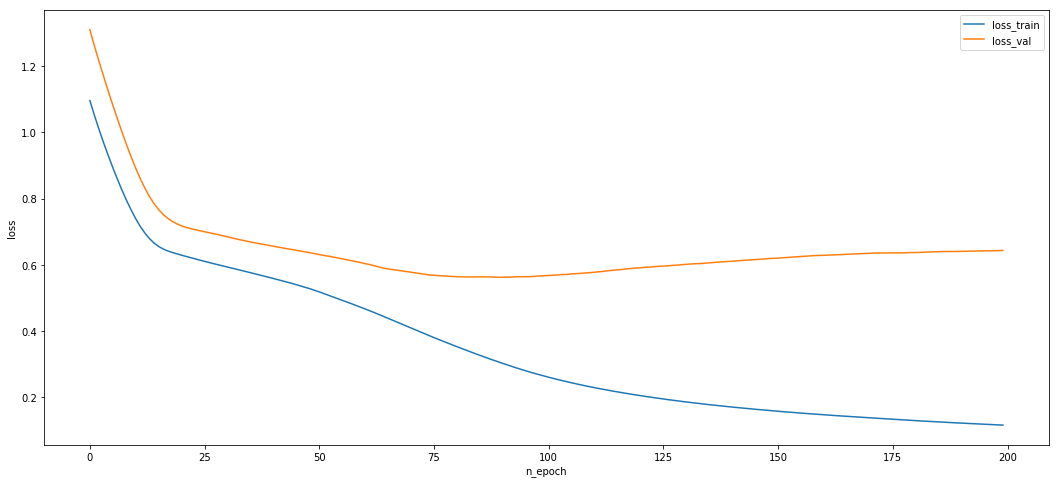

In [27]:
plt.figure(figsize=(18, 8))
# plt.plot(x, loss_train_arr, '-o', label='loss_train')
plt.plot(x, loss_train_arr, '-', label='loss_train')
plt.plot(x, loss_val_arr, '-', label='loss_val')

plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. 模型应用

In [28]:
print('val_pred= ', val_pred)
# 标准化数据还原 
predict_val = inverse_StandardScaler(val_pred)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, 'base', 'DNN_V2'), index=False)
valPredict.head()

val_pred=  [[-0.00954507]
 [-0.00223577]
 [-0.01738671]
 ...
 [-0.02357959]
 [ 0.00167639]
 [-0.02063405]]
predict =  [[ 0.9611791 ]
 [ 1.6228946 ]
 [ 0.25126943]
 ...
 [-0.30937603]
 [ 1.977065  ]
 [-0.04271404]]


,user_id,prediction_pay_price
0,1518620,0.9612
1,906315,1.6229
2,493992,0.2513
3,2984816,0.1197
4,1387411,0.0000


In [29]:
#对测试数据进行预测
test_pred = sess.run(output_layer, {tf_x:test_X_ss})
print('test_pred = ', test_pred)

# 标准化数据还原 
test_pred = inverse_StandardScaler(test_pred)

test_pred =  [[-0.02818891]
 [-0.02244756]
 [-0.02776582]
 ...
 [ 0.01945571]
 [-0.01660933]
 [-0.0171954 ]]
predict =  [[-0.72666126]
 [-0.2068923 ]
 [-0.6883581 ]
 ...
 [ 3.586639  ]
 [ 0.32164606]
 [ 0.26858947]]


In [30]:
#输出预测后的数据
testPredict = generate_summit(test_pred)
testPredict.to_csv(out_name %(summit_path, 'base', 'DNN_V2'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,1.8440
4,14937,0.0000


In [23]:
# 最后要关闭 
sess.close()